<a href="https://colab.research.google.com/github/pragasv/health-vision/blob/master/analysis_data_2__with_mom's_input_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from dateutil import parser
import re 
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,plot_confusion_matrix

import tensorflow as tf 
import keras 
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.compat.v1 import set_random_seed
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.wrappers.scikit_learn import KerasClassifier

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
## upload files 
from google.colab import files
uploaded = files.upload()

Saving data2_new_colomns.csv to data2_new_colomns.csv
Saving Patient-Medical-Data-for-Novel-Coronavirus-COVID-19.csv to Patient-Medical-Data-for-Novel-Coronavirus-COVID-19.csv


In [9]:
uploaded2 = files.upload()

Saving chronic.csv to chronic (1).csv
Saving symptoms.csv to symptoms (1).csv


In [0]:
## new colomn to associate risk level based on mothers input  
import io

data2 = pd.read_csv(io.BytesIO(uploaded['Patient-Medical-Data-for-Novel-Coronavirus-COVID-19.csv']))

data2_new = pd.read_csv(io.BytesIO(uploaded['data2_new_colomns.csv']))
symptoms_data = pd.read_csv(io.BytesIO(uploaded2['symptoms.csv']))
chronic_data = pd.read_csv(io.BytesIO(uploaded2['chronic.csv']))


In [0]:
#tf.enable_eager_execution()

In [0]:
# delete unused data 

del data2_new['DateOfDeath']
del data2_new['DateOfDischarge']
del data2_new['GeoPosition']
del data2_new['DateOfOnsetSymptoms']
del data2_new['DateOfAdmissionHospital']
del data2_new['DateOfConfirmation']

In [0]:
## duplicate rows delted 
data2.drop_duplicates(keep = 'first', inplace = True, ignore_index = 1)

In [0]:
## one hot encoding - clustering purpose 
df1 = pd.DataFrame()  

for i in range(len(data2)):
    if data2['Symptoms'][i] != """Missing["NotAvailable"]""" :
        a = re.findall('"([^"]*)"',data2['Symptoms'][i])
        df1 = pd.concat([df1,pd.DataFrame([a])], ignore_index=True)
    else: 
        df1 = pd.concat([df1,pd.DataFrame([0])], ignore_index=True)

## identify unique items 
a,b = df1.shape
items = []
for i in range(b):
    items += df1[i].unique().tolist()
items = list(set(items))

encoded_vals = []
for index, row in df1.iterrows():
    labels = {}
    uncommons = list(set(items) - set(row))
    commons = list(set(items).intersection(row))
    for uc in uncommons:
        labels[uc] = 0
    for com in commons:
        labels[com] = 1
    encoded_vals.append(labels)
encoded_vals[0]

#one hot encoded data frame 
ohe_df = pd.DataFrame(encoded_vals)
#delete 0 and NaN colomn 
del ohe_df[0]
del ohe_df[float('nan')]

### ohe - chronic diseases
df = pd.DataFrame()  
for i in range(len(data2)):
    if data2['ChronicDiseases'][i] != """Missing["NotAvailable"]""" :
        a = re.findall('"([^"]*)"',data2['ChronicDiseases'][i])
        df = pd.concat([df,pd.DataFrame([a])], ignore_index=True)
    else: 
        df = pd.concat([df,pd.DataFrame([0])], ignore_index=True)

## identify unique items 
a,b = df.shape
items = []
for i in range(b):
    items += df[i].unique().tolist()
items = list(set(items))


encoded_vals = []
for index, row in df.iterrows():
    labels = {}
    uncommons = list(set(items) - set(row))
    commons = list(set(items).intersection(row))
    for uc in uncommons:
        labels[uc] = 0
    for com in commons:
        labels[com] = 1
    encoded_vals.append(labels)
encoded_vals[0]

#one hot encoded data frame 
ohe_df_2 = pd.DataFrame(encoded_vals)
#delete 0 and NaN colomn 
del ohe_df_2[0]
del ohe_df_2[float('nan')]


In [14]:
ohe_df.columns

Index(['asymptomatic', 'myocardial dysfunction', 'sepsis', 'arrhythmia',
       'dry mouth', 'weakness', 'poor physical condition', 'malaise',
       'cardiogenic shock', 'rhinitis', 'shortness of breath',
       'lack of energy', 'aggressive pulmonary symptomatology',
       'acute respiratory infection', 'pneumonitis', 'heart failure',
       'vomiting', 'cardiopulmonary arrest', 'body soreness', 'inappetence',
       'congestive heart failure', 'systemic weakness', 'anorexia',
       'dysphagia', 'rhinorrhea', 'acute respiratory disease', 'discharge',
       'similar to a respiratory infection', 'mild symptoms', 'joint pain',
       'conjunctivitis', 'acute coronary syndrome', 'toothache',
       'severe acute respiratory distress syndrome', 'sore throat',
       'influenza', 'abdominal pain', 'gasp', 'sweating', 'sore limbs',
       'dry throat', 'pharyngalgia', 'hypoxia', 'wheezing', 'headache',
       'breathing difficulty', 'full body slump', 'pneumonia',
       'flu-like sympto

In [0]:
### identify the top 10  symptoms and 5 chronic diseases 
top_sym = ['fever','cough','pneumonia','acute respiratory distress syndrome','rhinorrhea','chest pain','headache',
           'shortness of breath','DegreesCelsius','fatigue','myalgias','malaise']

for i in ohe_df.columns:
    if i not in top_sym:
        del ohe_df[i]

In [0]:
top_chr = ['hypertension','asthma','coronary heart disease','chronic obstructive pulmonary disease','chronic kidney disease']

for i in ohe_df_2.columns:
    if i not in top_chr:
        del ohe_df_2[i]

In [17]:
ohe_df_2.shape

(9423, 5)

In [0]:
data2_new = pd.concat([data2_new,ohe_df,ohe_df_2],axis=1)

In [0]:
### delete some unwanted colomns to send for clustering 

del data2_new['Symptoms']
del data2_new['ChronicDiseases']

In [0]:
### mapping of all true to 1  
data2_new[['ChronicDiseaseQ','SequenceAvailable','DischargedQ','DeathQ']] = (data2_new[['ChronicDiseaseQ','SequenceAvailable','DischargedQ','DeathQ']] == 'True').astype(int)

In [0]:
##find a way to catagorize the labels  - mom's inputs 
label_chronic = []
label_symptom = []

for i in range(len(data2_new)):
    val_ch = 0 
    val_sy = 0 
    
    for j in chronic_data.columns:
        try:
            val_ch += int(data2_new[j][i]) * int(chronic_data[j][0])
        except: 
            continue
            #print('issues in chronic: ' + j )
    label_chronic.append(val_ch)
    
    
    
    for k in symptoms_data.columns:
        try:
            val_sy += int(data2_new[k][i]) *int(symptoms_data[k][0])
        except: 
            continue
            #print('issues in symptoms: ' + k )
    label_symptom.append(val_sy)
    

In [22]:
severity =np.array(label_chronic) + np.array(label_symptom)
print((pd.DataFrame(severity))[0].value_counts())

#bininig maually 
digitized = []

for i in range(len(severity)):
    if severity[i]==0 : 
        digitized.append(0)
    elif severity[i]<=5 : 
        digitized.append(1)
    elif severity[i]<=12 : 
        digitized.append(2)
    else:
        digitized.append(3)

0     8659
5      315
10     196
15      42
8       34
6       30
11      23
1       22
7       20
4       15
9       14
2       12
13      10
12      10
14       7
16       4
3        3
18       3
17       2
19       1
20       1
Name: 0, dtype: int64


In [23]:
print((pd.DataFrame(digitized))[0].value_counts())

0    8659
1     367
2     327
3      70
Name: 0, dtype: int64


In [0]:
data2_new = pd.concat([data2_new,pd.DataFrame(label_chronic),pd.DataFrame(label_symptom),pd.DataFrame(digitized)],axis=1)

In [0]:
##################################
### remove unnecessary columns ###
##################################

In [0]:
df = data2_new[(data2_new['Age'].isna()) & (data2_new['Age'] != 0)]

In [26]:
df.shape

(119, 32)

# # training

In [0]:
X = (data2_new[:9304].iloc[:,:-3]).to_numpy()
y = (data2_new[:9304].iloc[:,-1]).to_numpy()

## split train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [28]:
### trying NN approach 
set_random_seed(2)
model = tf.keras.models.Sequential([
                             tf.keras.layers.Dense(64,input_dim=29,activation="relu"),
                             tf.keras.layers.Dense(128,activation="relu"),
                             tf.keras.layers.Dense(128,activation="relu"),
                             tf.keras.layers.Dense(4,activation="softmax")
                            # tf.keras.layers.Dense(3,input_dim = 149,activation="softmax")
])

model.compile(optimizer="adam",loss = "sparse_categorical_crossentropy",metrics = ["acc"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1920      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 27,268
Trainable params: 27,268
Non-trainable params: 0
_________________________________________________________________


In [29]:
history = model.fit(X_train,y_train,validation_split=0.33,epochs = 30, batch_size = 10)

Epoch 1/30
499/499 [==============================] - 2s 4ms/step - loss: 0.4656 - acc: 0.9178 - val_loss: 0.3022 - val_acc: 0.9162
Epoch 2/30
499/499 [==============================] - 2s 4ms/step - loss: 0.1531 - acc: 0.9513 - val_loss: 0.1424 - val_acc: 0.9503
Epoch 3/30
499/499 [==============================] - 2s 4ms/step - loss: 0.0907 - acc: 0.9655 - val_loss: 0.0780 - val_acc: 0.9740
Epoch 4/30
499/499 [==============================] - 2s 4ms/step - loss: 0.0730 - acc: 0.9739 - val_loss: 0.0794 - val_acc: 0.9658
Epoch 5/30
499/499 [==============================] - 2s 4ms/step - loss: 0.0709 - acc: 0.9773 - val_loss: 0.0547 - val_acc: 0.9801
Epoch 6/30
499/499 [==============================] - 2s 4ms/step - loss: 0.0572 - acc: 0.9805 - val_loss: 0.0572 - val_acc: 0.9796
Epoch 7/30
499/499 [==============================] - 2s 4ms/step - loss: 0.0553 - acc: 0.9822 - val_loss: 0.0533 - val_acc: 0.9809
Epoch 8/30
499/499 [==============================] - 2s 4ms/step - loss: 0.

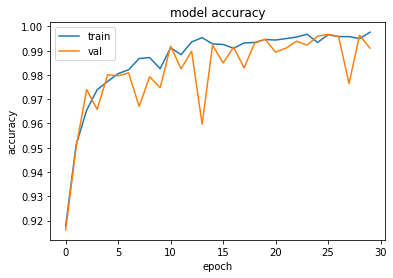

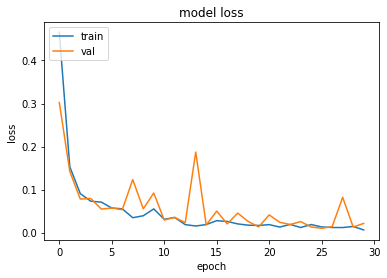

In [30]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

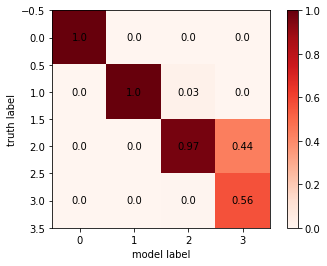

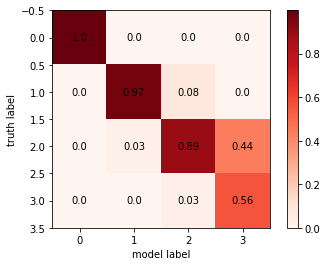

59/59 - 0s - loss: 0.0368 - acc: 0.9876
Untrained model, accuracy: 98.76%


In [31]:
predict=model.predict(X_train)
predict = np.argmax(predict, axis = -1)

### performance on train set 
cm = confusion_matrix(y_train,predict, normalize= 'pred')
plt.imshow(cm,interpolation='none',cmap='Reds')
plt.colorbar()
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, round(z,2), ha='center', va='center')
plt.xlabel("model label")
plt.ylabel("truth label")
plt.show()

#performance on test set 
predict=model.predict(X_test)
predict = np.argmax(predict, axis = -1)

cm = confusion_matrix(y_test,predict,normalize= 'pred')
plt.imshow(cm,interpolation='none',cmap='Reds')
plt.colorbar()
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i,  round(z,2), ha='center', va='center')
plt.xlabel("model label")
plt.ylabel("truth label")
plt.show()

# Evaluate the model
loss, acc = model.evaluate(X_test,  y_test, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100*acc))

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("model_12sym_5chr.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_12sym_5chr.h5")
print("Saved model to disk")

Saved model to disk


# grid searching 

In [0]:
# Function to create model, required for KerasClassifier
def create_model(dense_layer_sizes,learning_rate):
# create model
    model = Sequential()
    model.add(Dense(64, input_dim=29, activation='relu'))
    for i in dense_layer_sizes:
        model.add(Dense(i, activation='relu'))
        #model.add(Dense(128, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    # Compile model
    opt = keras.optimizers.Adam(learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

seed = 2
np.random.seed(seed)
model = KerasClassifier(build_fn=create_model, verbose=0)

In [0]:
batch_size = [1,2,5,7,10, 20 ]
epochs=[30,40,50,60,70]
learn_rate = [0.0001, 0.001, 0.01]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8]
dense_layer_sizes = [(64), (32, 32), (64, 64),(128,128)]

scorers = {
        'precision_score': make_scorer(precision_score),
        'recall_score': make_scorer(recall_score),
        'accuracy_score': make_scorer(accuracy_score)
        }

param_grid = dict(epochs=epochs, batch_size=batch_size, learning_rate = learn_rate, dense_layer_sizes = dense_layer_sizes )

In [0]:
#my_classifier = KerasClassifier(model, batch_size=32, epochs=10)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 10)

In [35]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [0]:
# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

print('\n')
print('all results : ')
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))